# **Project 3: Should you invest in Ray Dalio’s all weather portfolio?**

## **Introduction**

You currently hold a portfolio that is 100% equity index funds. However, after reading a blog, you are considering to invest in Ray Dalio’s all weather portfolio.

Here, we investigate three portfolios to make a decision about the portfolio that you should invest in:

> 1) Current portfolio of 100% equity index funds: SPY (S&P 500 ETF)

> 2) A balanced portfolio of 60% equity and 40% bonds: SPY and TLT (long-term U.S. government bond ETF)

> 3) Ray Dalio’s all weather portfolio: SPY, TLT, IEF (intermediate-term U.S. government bond ETF), and GLD (gold ETF)


The portfolios are compared on various factors like Sharpe ratio, rolling returns, maximum drawdowns, rebalancing and leverage. 


Appropriate modules and packages are loaded at this stage.

In [1]:

import numpy as np
import pandas as pd
import pandas_datareader as web
import plotly.express as px
import pandas_datareader as pdr
import datetime
import pandas_datareader.data as web
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
# The yfinance package provides "a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance.
# To avoid repeated calls to Yahoo! Finance's advanced programming interface (API), we will use the requests-cache package.
!pip install yfinance
!pip install requests-cache

In [3]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [4]:
# We can download data with yahoo finance.
import yfinance as yf
import requests_cache
session = requests_cache.CachedSession()
from pandas_datareader import data

We download the four ETF's data from yahoo finance. 

In [5]:
full_portfolio = yf.download(tickers='SPY TLT IEF GLD', session=session)

[*********************100%***********************]  4 of 4 completed


In [6]:
full_portfolio

Adj Close                    ...       Volume                         
                 GLD      IEF      SPY  ...          IEF        SPY           TLT
Date                                    ...                                      
1993-01-29       nan      nan  25.7174  ...          nan    1003200           nan
1993-02-01       nan      nan  25.9003  ...          nan     480500           nan
1993-02-02       nan      nan  25.9552  ...          nan     201300           nan
1993-02-03       nan      nan  26.2295  ...          nan     529400           nan
1993-02-04       nan      nan  26.3393  ...          nan     531500           nan
...              ...      ...      ...  ...          ...        ...           ...
2021-12-10  166.5800 115.2342 470.7400  ... 5051500.0000   76949400 14297300.0000
2021-12-13  167.0000 115.7837 466.5700  ... 5706900.0000   87724700 17860500.0000
2021-12-14  165.4400 115.5838 463.3600  ... 4749500.0000   97264100 14015500.0000
2021-12-15  166.1500 115.4140 470.6000  ... 8428000.0000  116899300 25383900.0000
2021-12-16  168.1600 115.7500 466.4500  ... 9085000.0000  116332000 18677400.0000

[7275 rows x 24 columns]

We focus on 'Adj close' values from the data set and drop the null values.

In [7]:
full_portfolio = full_portfolio['Adj Close']


In [8]:
full_portfolio= full_portfolio.dropna()

In [9]:
full_portfolio.head()

,GLD,IEF,SPY,TLT
Date,,,,
2004-11-18,44.3800,55.0613,85.0503,51.6190
2004-11-19,44.7800,54.7595,84.1048,51.2070
2004-11-22,44.9500,54.7981,84.5059,51.4739
2004-11-23,44.7500,54.7467,84.6349,51.5377
2004-11-24,45.0500,54.8237,84.8354,51.5377


## **Optimised weights for All Weather Portfolio**

In [10]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from scipy.optimize import minimize
TOLERANCE = 1e-10


def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights


def get_weights(label=['GLD','IEF','SPY','TLT']):

    # We download the prices from Yahoo Finance
    prices = full_portfolio #pd.DataFrame([web.DataReader(t,
    #                                       'yahoo',
    #                                       start_date,
    #                                       end_date).loc[:, 'Adj Close']
    #                        for t in label],
    #                       index=label).T.asfreq('B').ffill()

    # We calculate the covariance matrix
    covariances = 252.0 * \
        prices.pct_change().cov().values

    # The desired contribution of each asset to the portfolio risk: we want all
    # asset to contribute equally
    assets_risk_budget = [1 / prices.shape[1]] * prices.shape[1]

    # Initial weights: equally weighted
    init_weights = [1 / prices.shape[1]] * prices.shape[1]

    # Optimisation process of weights
    weights = \
        _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

    # Convert the weights to a pandas Series
    weights = pd.Series(weights, index=prices.columns, name='weight')

    # It returns the optimised weights
    return weights

In [11]:
a= get_weights()
a

GLD   0.1532
IEF   0.4195
SPY   0.2316
TLT   0.1957
Name: weight, dtype: float64

## **All Weather Portfolio- Return, Volatility, Risk Contribution, Cumulative Returns**

Weighted return of All Weather Portfolio

In [12]:
abcd= full_portfolio.pct_change().dropna()
weighted_returns_full_portfolio = abcd.dot(a)
weighted_returns_full_portfolio1= 252 * weighted_returns_full_portfolio.mean()
weighted_returns_full_portfolio1

0.075130696595328

Volatility of All Weather Portfolio

In [13]:
volatility_full_portfolio= 252 * abcd.cov()
volatility_full_portfolio
sd_full_portfolio = np.sqrt(np.dot(a, volatility_full_portfolio.dot(a)))
sd_full_portfolio

0.0648311951957294

Risk contribution from ETFs in All Weather Portfolio

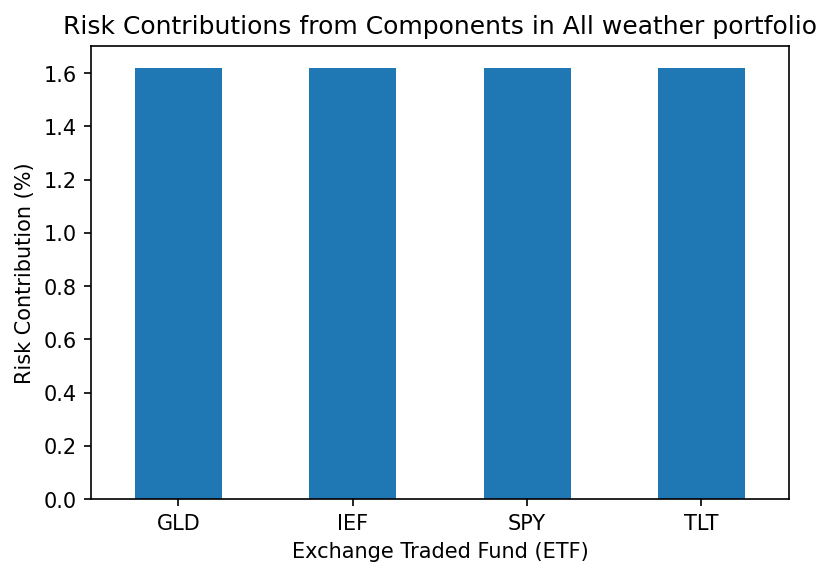

In [14]:
(100 * a * volatility_full_portfolio.dot(a) / sd_full_portfolio).plot(kind='bar')
plt.xlabel('Exchange Traded Fund (ETF)')
plt.ylabel('Risk Contribution (%)')
plt.title('Risk Contributions from Components in All weather portfolio')
plt.xticks(rotation=0)
plt.show()

Cumulative Returns in All Weather Portfolio

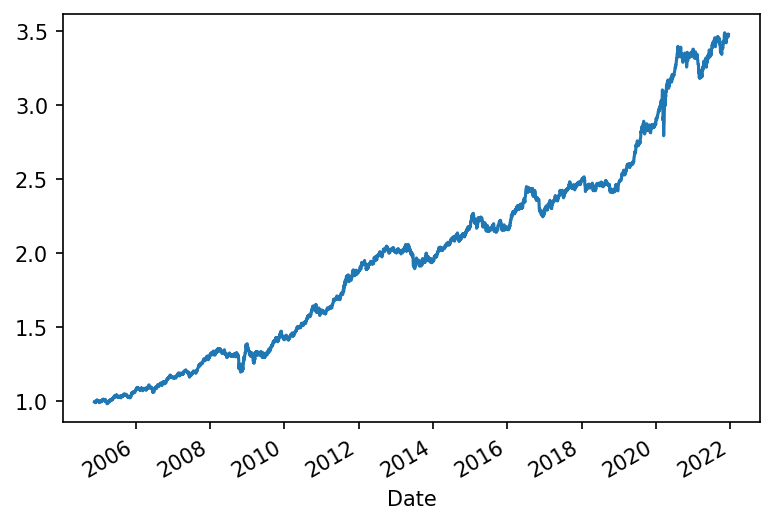

In [15]:
cumulative_ret1 = (weighted_returns_full_portfolio + 1).cumprod()
cumulative_ret1.plot()

All weather portfolio is a conservative portfolio which encompasses all types of assets into the portfolio. This helps to diversify the portfolio resulting in better return-risk.

## **Balanced portfolio- Return, Volatility, Risk Contribution, Cumulative Returns**

In [16]:
second_port = yf.download('SPY TLT', session=session)
second_port.dropna()

[*********************100%***********************]  2 of 2 completed


Adj Close             Close  ...     Open     Volume              
                 SPY      TLT      SPY  ...      TLT        SPY           TLT
Date                                    ...                                  
2002-07-30   62.5959  42.2070  90.9400  ...  81.7500   47532200     6100.0000
2002-07-31   62.7473  42.7300  91.1600  ...  81.9500   44669900    29400.0000
2002-08-01   61.1091  42.9733  88.7800  ...  82.5400   66571900    25000.0000
2002-08-02   59.7394  43.4134  86.7900  ...  83.1600   51772900    52800.0000
2002-08-05   57.6606  43.6050  83.7700  ...  84.0400   47191300    61100.0000
...              ...      ...      ...  ...      ...        ...           ...
2021-12-10  470.7400 148.6924 470.7400  ... 149.9200   76949400 14297300.0000
2021-12-13  466.5700 150.8900 466.5700  ... 150.3900   87724700 17860500.0000
2021-12-14  463.3600 150.5304 463.3600  ... 150.3700   97264100 14015500.0000
2021-12-15  470.6000 149.0820 470.6000  ... 149.6100  116899300 25383900.0000
2021-12-16  466.4500 149.1400 466.4500  ... 148.7500  116332000 18677400.0000

[4882 rows x 12 columns]

In [17]:
returns1 = second_port['Adj Close'].pct_change().dropna()
returns1.head()

,SPY,TLT
Date,,
2002-07-31,0.0024,0.0124
2002-08-01,-0.0261,0.0057
2002-08-02,-0.0224,0.0102
2002-08-05,-0.0348,0.0044
2002-08-06,0.0337,-0.0085


In [18]:
w1 = pd.Series({'SPY': 0.6, 'TLT': 0.4})

Weighted Return of 60-40 Portfolio

In [19]:
weighted_returns_second_port = returns1.dot(w1)
weighted_returns_second_port.head()
weighted_returns_second_port1 = 252* weighted_returns_second_port.mean()
weighted_returns_second_port1

0.10311489801835307

In [20]:
weighted_returns_second_port.head()

Date
2002-07-31    0.0064
2002-08-01   -0.0134
2002-08-02   -0.0094
2002-08-05   -0.0191
2002-08-06    0.0168
dtype: float64

Volatility of 60-40 Portfolio

In [21]:
volatility_full_portfolio2= 252 * returns1.cov()
volatility_full_portfolio2
sd_full_portfolio2 = np.sqrt(np.dot(w1, volatility_full_portfolio2.dot(w1)))
sd_full_portfolio2

0.10522378260299908

Risk contribution of ETF's 60-40 Portfolio

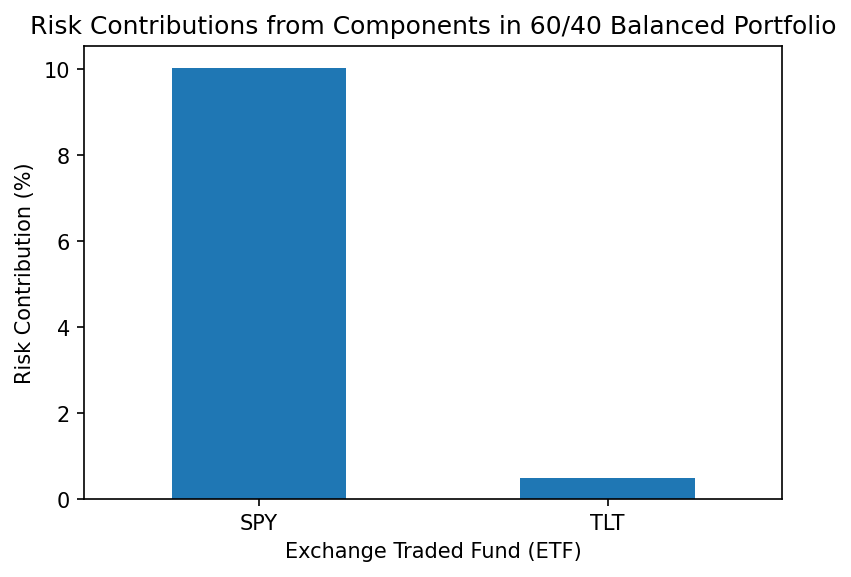

In [22]:
(100 * w1 * volatility_full_portfolio2.dot(w1) / sd_full_portfolio2).plot(kind='bar')
plt.xlabel('Exchange Traded Fund (ETF)')
plt.ylabel('Risk Contribution (%)')
plt.title('Risk Contributions from Components in 60/40 Balanced Portfolio')
plt.xticks(rotation=0)
plt.show()

Cumulative returns of 60-40 Portfolio

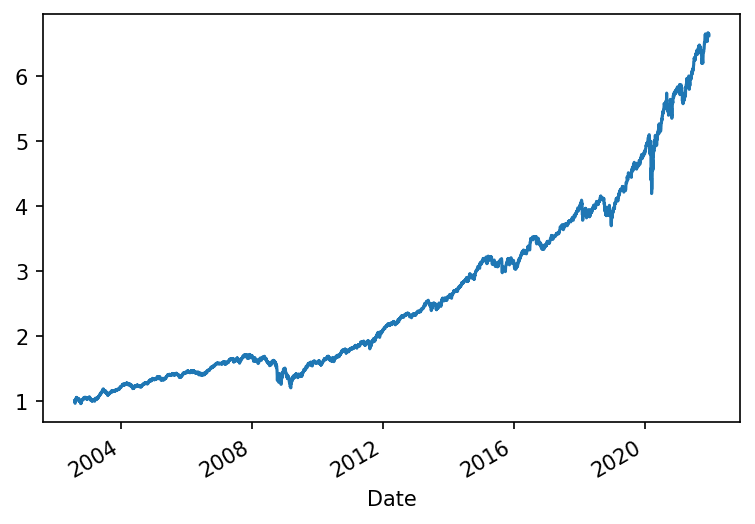

In [23]:
cumulative_ret2 = (weighted_returns_second_port + 1).cumprod()
cumulative_ret2.plot()


Balanced portfolio is true to its name. Its returns and volatility are in between the risks and returns of All weather portfolio and All equity portfolio. It is slightly more diversified than All equity portfolio hence it has lower risk. But almost all of its risk comes from equities which makes it a bit more volatile than All weather portfolio.

## **All Equity Portfolio - Return, Volatility, Risk Contribution, Cumulative Returns**

In [24]:
allequity = yf.download('SPY', session=session)
allequity.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.9688,43.9688,43.7500,43.9375,25.7174,1003200
1993-02-01,43.9688,44.2500,43.9688,44.2500,25.9003,480500
1993-02-02,44.2188,44.3750,44.1250,44.3438,25.9552,201300
1993-02-03,44.4062,44.8438,44.3750,44.8125,26.2295,529400
1993-02-04,44.9688,45.0938,44.4688,45.0000,26.3393,531500


Return of All Equity Portfolio

In [25]:
allequity_returns = allequity['Adj Close'].pct_change().dropna()
allequity_returns1 = 252 * allequity_returns.mean()
allequity_returns1

0.11796092679437141

Volatility of All Equity Portfolio

In [26]:
vol_allequity_returns=  allequity_returns.std()
vol_allequity_returns= vol_allequity_returns * np.sqrt(252)
vol_allequity_returns

0.18723582883888165

Cumulative Returns of All Equity Portfolio

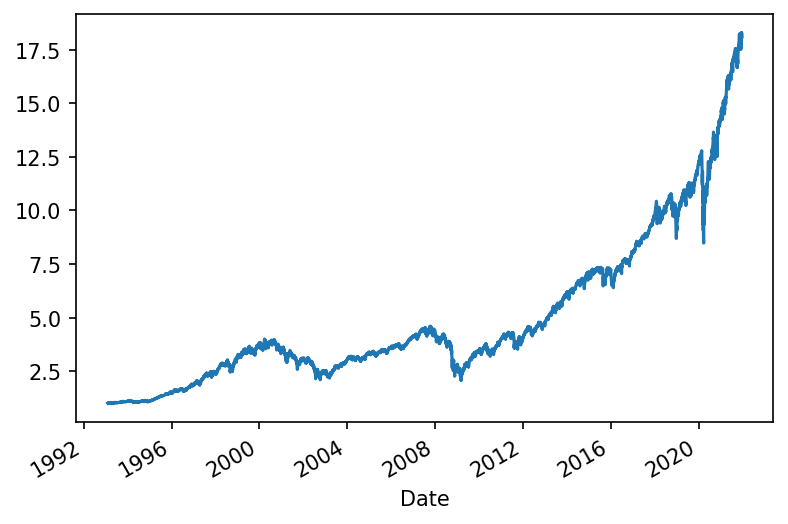

In [27]:
cumulative_ret3 = (allequity_returns + 1).cumprod()
cumulative_ret3.plot()
### cumulative_ret3^(1/no. of years)-1= annualized cumulative return

All equity portfolio has the highest return,volatility among its comparables. The reason is that it is a non-diversified portfolio and hence there is higher risk which results in higher returns.

## **Sharpe Ratios for Full Sample**

Sharpe ratio: One of the most popular performance evaluation metrics, it measures the excess return (over the risk-free rate) per unit of standard deviation. When no risk-free rate is provided, the default assumption is that it is equal to 0%. The greater the Sharpe ratio, the better the portfolio's risk-adjusted performance.

In [28]:
pdr.famafrench.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [29]:
ff = pdr.get_data_famafrench(
'F-F_Research_Data_Factors_daily',
start='1993',
session=session
)

In [30]:
ff = ff[0] / 100

Now we will add ff data into the returns dataframe of All Weather Portfolio returns

In [31]:
weighted_returns_full_portfolio
df001= ff.merge(weighted_returns_full_portfolio.to_frame(), left_index=True, right_index=True)
df001.columns =['Mkt-RF', 'SMB', 'HML', 'RF', 'WEIGHTEDR']
df001.head()

,Mkt-RF,SMB,HML,RF,WEIGHTEDR
Date,,,,,
2004-11-19,-0.0111,-0.0020,0.0076,0.0001,-0.0051
2004-11-22,0.0060,0.0042,0.0043,0.0001,0.0030
2004-11-23,0.0006,0.0028,0.0037,0.0001,-0.0005
2004-11-24,0.0047,0.0029,0.0012,0.0001,0.0022
2004-11-26,0.0012,0.0016,0.0020,0.0001,-0.0022


Adjusted Returns (r-rf)

In [32]:
df001['RETURN_RF'] = df001['WEIGHTEDR'] - df001['RF']
df001.head()
df001['RETURN_RF']

Date
2004-11-19   -0.0051
2004-11-22    0.0029
2004-11-23   -0.0005
2004-11-24    0.0021
2004-11-26   -0.0022
               ...  
2021-10-25    0.0025
2021-10-26    0.0012
2021-10-27    0.0053
2021-10-28    0.0004
2021-10-29   -0.0001
Name: RETURN_RF, Length: 4266, dtype: float64

Calculating the **Sharpe Ratio** with Full Sample of All Weather Portfolio:

In [33]:
avg_returns_allweather = 252 * df001['RETURN_RF'].mean()
vol_allweather = sd_full_portfolio
sr_allweather = avg_returns_allweather / sd_full_portfolio
sr_allweather

0.976783506158298

**60-40 Portfolio Sharpe Ratio**

In [34]:
weighted_returns_second_port
df002= ff.merge(weighted_returns_second_port.to_frame(), left_index=True, right_index=True)
df002.columns =['Mkt-RF', 'SMB', 'HML', 'RF', 'WEIGHTEDR']
df002.head()

,Mkt-RF,SMB,HML,RF,WEIGHTEDR
Date,,,,,
2002-07-31,0.0065,-0.0247,-0.0016,0.0001,0.0064
2002-08-01,-0.0268,0.0146,0.0103,0.0001,-0.0134
2002-08-02,-0.0236,-0.0030,-0.0072,0.0001,-0.0094
2002-08-05,-0.0334,0.0109,0.0045,0.0001,-0.0191
2002-08-06,0.0303,0.0020,-0.0052,0.0001,0.0168


In [35]:
df002['RETURN_RF'] = df002['WEIGHTEDR'] - df002['RF']
df002.head()
df002['RETURN_RF']

Date
2002-07-31    0.0063
2002-08-01   -0.0134
2002-08-02   -0.0094
2002-08-05   -0.0192
2002-08-06    0.0167
               ...  
2021-10-25    0.0026
2021-10-26    0.0038
2021-10-27    0.0046
2021-10-28    0.0044
2021-10-29    0.0024
Name: RETURN_RF, Length: 4848, dtype: float64

Calculating the **Sharpe Ratio** with Full Sample of 60-40 Portfolio





In [36]:
avg_returns_secondport = 252 * df002['RETURN_RF'].mean()
vol_secondport = sd_full_portfolio2
sr_secondport = avg_returns_secondport / vol_secondport
sr_secondport

0.8686578500722828

**All Equity Portfolio Sharpe Ratio**

In [37]:
allequity_returns
df003= ff.merge(allequity_returns, left_index=True, right_index=True)
df003.columns =['Mkt-RF', 'SMB', 'HML', 'RF', 'WEIGHTEDR']
df003.head()

,Mkt-RF,SMB,HML,RF,WEIGHTEDR
Date,,,,,
1993-02-01,0.0084,-0.0056,0.0023,0.0001,0.0071
1993-02-02,0.0014,0.0012,0.0028,0.0001,0.0021
1993-02-03,0.0095,-0.0009,0.0027,0.0001,0.0106
1993-02-04,0.0055,-0.0043,0.0068,0.0001,0.0042
1993-02-05,-0.0033,-0.0046,0.0065,0.0001,-0.0007


In [38]:
df003['RETURN_RF'] = df003['WEIGHTEDR'] - df003['RF']
df003.head()
df003['RETURN_RF']

Date
1993-02-01    0.0070
1993-02-02    0.0020
1993-02-03    0.0105
1993-02-04    0.0041
1993-02-05   -0.0008
               ...  
2021-10-25    0.0054
2021-10-26    0.0009
2021-10-27   -0.0044
2021-10-28    0.0096
2021-10-29    0.0020
Name: RETURN_RF, Length: 7241, dtype: float64

Calculating the **Sharpe Ratio** with Full Sample of All Equity Portfolio


In [39]:
avg_returns_allequity = 252 * df003['RETURN_RF'].mean()
vol_allequity = vol_allequity_returns
sr_allequity = avg_returns_allequity / vol_allequity
sr_allequity

0.5106055157216702

All weather portfolio has the highest Sharpe Ratio among the three, which is a good indication of better return-risk trade-off.

##**Rolling Annual Returns with 252D Windows**##


Cumulative Return for Rolling 1-year periods for All Weather Portfolio

In [40]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [41]:
means = df001['WEIGHTEDR'].rolling('252D').apply(multi_period_return) 
means.tail()

Date
2021-10-25   0.0243
2021-10-26   0.0342
2021-10-27   0.0398
2021-10-28   0.0422
2021-10-29   0.0464
Name: WEIGHTEDR, dtype: float64

Cumulative Return for Rolling 1-year periods for Balanced Portfolio

In [42]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [43]:
means1 = df002['WEIGHTEDR'].rolling('252D').apply(multi_period_return) 
means1.tail()

Date
2021-10-25   0.0977
2021-10-26   0.1093
2021-10-27   0.1114
2021-10-28   0.1211
2021-10-29   0.1310
Name: WEIGHTEDR, dtype: float64

Cumulative Return for Rolling 1-year periods for All Equity Portfolio

In [44]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [45]:
means2 = df003['WEIGHTEDR'].rolling('252D').apply(multi_period_return) 
means2.tail()

Date
2021-10-25   0.1716
2021-10-26   0.1736
2021-10-27   0.1682
2021-10-28   0.1845
2021-10-29   0.1890
Name: WEIGHTEDR, dtype: float64

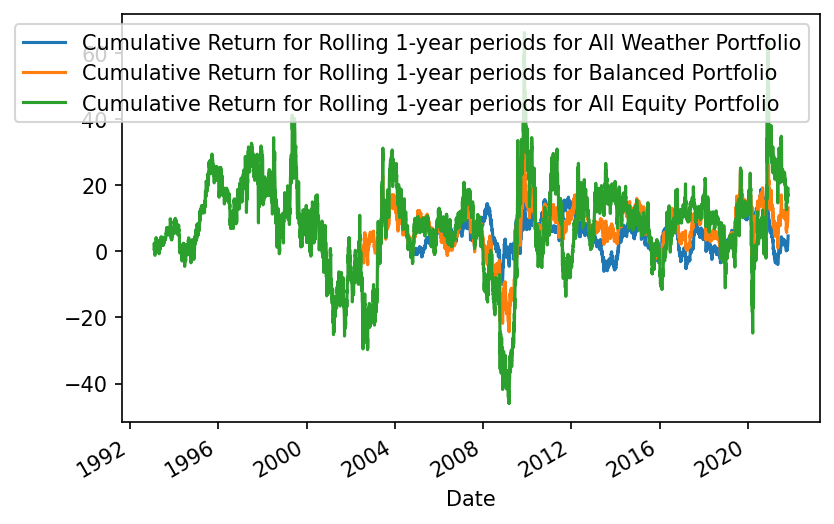

In [46]:
means.mul(100).plot(label='Cumulative Return for Rolling 1-year periods for All Weather Portfolio')
means1.mul(100).plot(label='Cumulative Return for Rolling 1-year periods for Balanced Portfolio')
means2.mul(100).plot(label='Cumulative Return for Rolling 1-year periods for All Equity Portfolio')
plt.legend()
plt.show()

##**Rolling Sharpe Ratio 252 Trading Days**

Rolling Sharpe Ratio for All Weather Portfolio

In [47]:
rolling_sr_allweather= np.sqrt(252) * df001['RETURN_RF'].rolling(252).mean() / df001['RETURN_RF'].rolling(252).std()

Rolling Sharpe Ratio for 60-40 Portfolio

In [48]:
rolling_sr_secondport=np.sqrt(252) * df002['RETURN_RF'].rolling(252).mean() / df002['RETURN_RF'].rolling(252).std()


Rolling Sharpe Ratio for All Equity Portfolio

In [49]:
rolling_sr_allequity= np.sqrt(252) * df003['RETURN_RF'].rolling(252).mean() / df003['RETURN_RF'].rolling(252).std()

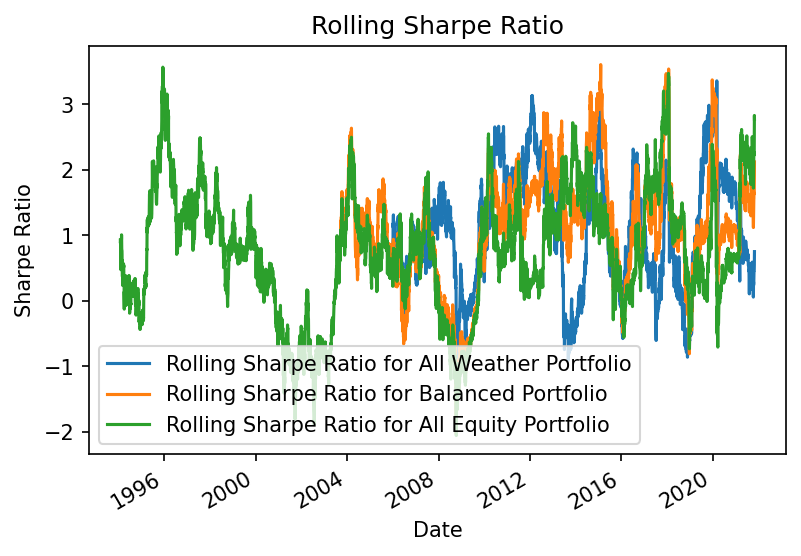

In [50]:
rolling_sr_allweather.plot(label='Rolling Sharpe Ratio for All Weather Portfolio')
rolling_sr_secondport.plot(label='Rolling Sharpe Ratio for Balanced Portfolio')
rolling_sr_allequity.plot(label='Rolling Sharpe Ratio for All Equity Portfolio')
plt.title('Rolling Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

## **Rolling Maximum Draw-Downs**


In [51]:
def drawdown(r):
    cumprod = (1 + r).cumprod()
    return cumprod / (cumprod).cummax() - 1

In [52]:
def max_drawdown(r):
    return np.max(np.abs(drawdown(r)))

Rolling Maximum Draw-Down for All Weather Portfolio

In [53]:
max_drawdown(df001['WEIGHTEDR'])

0.11760264198033998

Rolling Maximum Draw-Down for 60-40 Portfolio

In [54]:
max_drawdown(df002['WEIGHTEDR'])

0.2992281318995852

Rolling Maximum Draw-Down for All Equity Portfolio

In [55]:
max_drawdown(df003['WEIGHTEDR'])

0.5518945881409234

All weather portfolio has the lowest MDD, while all equity portfolio has the highest MDD. This suggests that the volatility is controlled in the all weather portfolio.

## **Comparing Daily Rebalancing with Annual Rebalancing of the Portfolios**

Annual Rebalancing of All Weather Portfolio


In [56]:
reb_allweather= abcd.groupby(pd.Grouper(freq='Y')).apply(lambda x: (1 + x).cumprod().shift().fillna(1) * a)

In [57]:
w_d_y1 = reb_allweather.div(reb_allweather.sum(axis=1), axis=0)

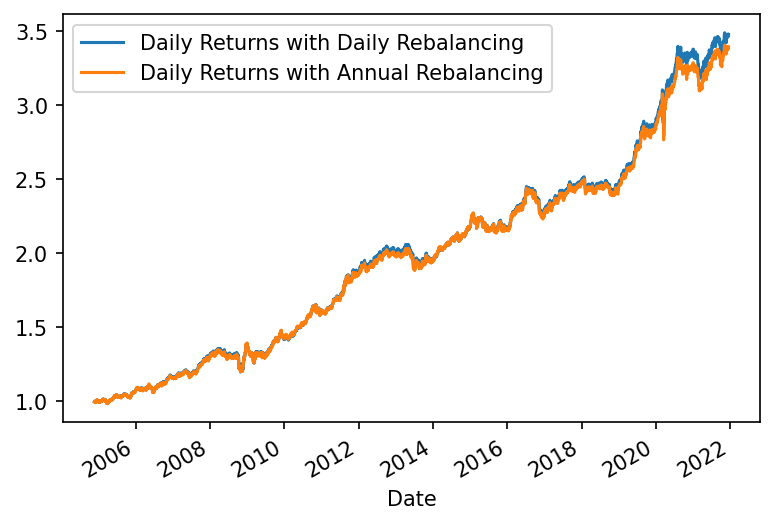

In [58]:
rp_d_y1 = (abcd * w_d_y1).sum(axis=1)
cumulative_ret1.plot(label='Daily Returns with Daily Rebalancing')
rp_d_y1.add(1).cumprod().plot(label='Daily Returns with Annual Rebalancing')
plt.legend()
plt.show()

Annual Rebalancing of 60-40 Portfolio


In [59]:
reb_secondport= returns1.groupby(pd.Grouper(freq='Y')).apply(lambda x: (1 + x).cumprod().shift().fillna(1) * w1)

In [60]:
w_d_y2 = reb_secondport.div(reb_secondport.sum(axis=1), axis=0)

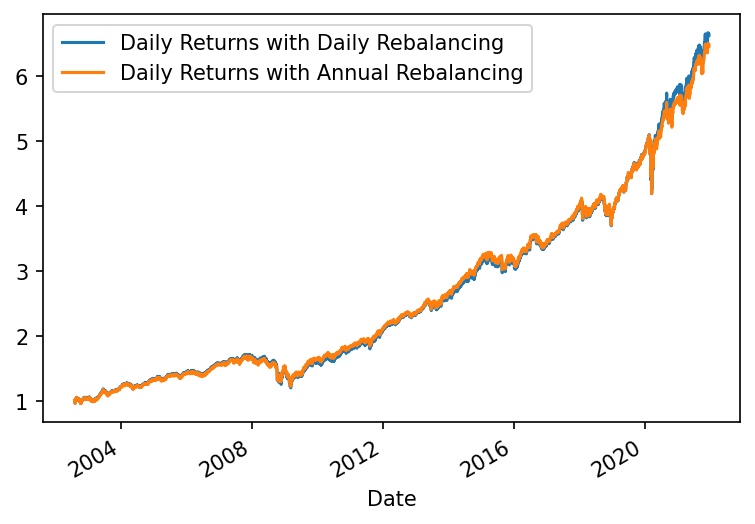

In [61]:
rp_d_y2 = (returns1 * w_d_y2).sum(axis=1)
cumulative_ret2.plot(label='Daily Returns with Daily Rebalancing')
rp_d_y2.add(1).cumprod().plot(label='Daily Returns with Annual Rebalancing')
plt.legend()
plt.show()


Both rebalancing graphs represent the same picture. The daily returns for annual rebalancing and daily rebalancing seem to overlap on most of its path. This suggests that daily rebalancing of portfolios is not required. Moreover, it is expensive and time consuming to balance the portfolio everyday. And transaction costs and bid-ask spread hurt the earnings for the investors. 

On the other hand,  if the portfolio is rarely rebalanced, then it would fail to detect the overwight/underwight assets and the overall returns of the portfolio would fall. Ultimately, also start losing the benefit of minimum variance and risk adjusted returns.

Both daily rebalancing and annual rebalancing have their pros and cons, although, the trade-off is very small. So, annual rebalancing is more practical to follow. 

## **Levering the Balanced and All Weather Portfolios**

We lever the balanced and all weather portfolios to have the same full-sample annualized return as the 100% equity portfolio.
The following formula is used for the same:



> leveraged portfolio return = return on investment +(( debt/equity) * (return on investment - cost of debt))





where,



*leveraged portfolio return= full-sample annualized  cumulative return of the 100% equity portfolio*

*return on investment = return on All Weather Portfolio/ Balanced Portfolio*

*cost of debt= risk free rate*


Annualized cumulative return for All Weather Portfolio = 0.072

In [62]:
cumulative_ret1[-1]
### ann_cumr_allweath = cumulative_ret1[-1]^(1/(2021-2004))-1
### ann_cumr_allweath= (3.479 ^(0.056))-1
### ann_cumr_allweath = 0.072

3.4752635108892194

Annualized cumulative return for 60-40 Portfolio = 0.105



In [63]:
cumulative_ret2[-1]
### ann_cumr_6040 = cumulative_ret2[-1]^(1/(2021-2002))-1
### ann_cumr_6040= (6.643 ^(0.053))-1
### ann_cumr_6040 = 0.105

6.617394845186646

Annualized cumulative return for All Equity Portfolio = 0.110



In [64]:
cumulative_ret3[-1]
### ann_cumr_alleq = cumulative_ret2[-1]^(1/(2021-1993))-1
### ann_cumr_alleq= (18.28 ^(0.036))-1
### ann_cumr_alleq = 0.110

18.137539776942

In [65]:
y= ff['RF'].mean()
y

8.859110315383064e-05

For All Weather Portfolio

D/E= (Annualized cumulative return for All Equity Portfolio- Annualized cumulative return for All Weather Portfolio)/ (Annualized cumulative return for All Weather Portfolio- RF)



D/E

In [66]:
D_E_allweather= (0.110-0.072)/(0.072-y)
D_E_allweather

0.5284279724585758

For 60-40 Portfolio

D/E= (Annualized cumulative return for All Equity Portfolio- Annualized cumulative return for Balanced Portfolio)/ (Annualized cumulative return for Balanced Portfolio- RF)

D/E

In [67]:
D_E_6040= (0.110-0.105)/(0.105-y)
D_E_6040

0.04765925891736179

From the above formula, it was evident that the all-weather portfolio has comparatively lower return so it would take a higher leverage to generate the same return.

If an investor is young and has a tolerance for risk, then he/she should invest in 100% equity. Although, as age increases, investors try to lower their risks and then invest into more diversified portfolios, like an all weather portfolio. 

Additionally, if the investor wants to increase the portfolio risk for sometime (if he expects that the market returns will be excellent), then he/she should increase the leverage in the All Weather Portfolio instead of investing completely in equities.

Sharpe ratio is another component to be looked at when discussing the levered positions in all weather. Investors prefer higher Sharpe ratio, i.e., more reward over a unit of risk. And from above analysis, it is clear that All Weather portfolio has the highest sharpe ratio among the three portfolios. Hence, we can use leverage to get better returns with higher risk. 

In conclusion, investing in All Weather portfolio remains a great option even after leverage is introduced. 


## **Mean Variance Efficient Frontier with Portfolio plots**

In [68]:
import scipy.optimize as sco

In [69]:
N_PORTFOLIOS = 10 ** 5

In [70]:
new_port = yf.download(tickers='SPY TLT IEF GLD', session=session)

[*********************100%***********************]  4 of 4 completed


In [71]:
new_port_r = new_port['Adj Close'].pct_change().dropna()

In [72]:
new_port_r=ff.merge(abcd, left_index=True, right_index=True)
new_port_r

,Mkt-RF,SMB,HML,RF,GLD,IEF,SPY,TLT
Date,,,,,,,,
2004-11-19,-0.0111,-0.0020,0.0076,0.0001,0.0090,-0.0055,-0.0111,-0.0080
2004-11-22,0.0060,0.0042,0.0043,0.0001,0.0038,0.0007,0.0048,0.0052
2004-11-23,0.0006,0.0028,0.0037,0.0001,-0.0044,-0.0009,0.0015,0.0012
2004-11-24,0.0047,0.0029,0.0012,0.0001,0.0067,0.0014,0.0024,0.0000
2004-11-26,0.0012,0.0016,0.0020,0.0001,0.0053,-0.0036,-0.0008,-0.0065
...,...,...,...,...,...,...,...,...
2021-10-25,0.0058,0.0049,-0.0016,0.0000,0.0069,0.0012,0.0054,-0.0015
2021-10-26,0.0004,-0.0071,-0.0032,0.0000,-0.0074,0.0012,0.0009,0.0083
2021-10-27,-0.0076,-0.0074,-0.0119,0.0000,0.0026,0.0056,-0.0044,0.0182


In [73]:
new_port_r['GLD_RF'] = new_port_r['GLD'] - new_port_r['RF']
new_port_r['SPY_RF'] = new_port_r['SPY'] - new_port_r['RF']
new_port_r['TLT_RF'] = new_port_r['TLT'] - new_port_r['RF']
new_port_r['IEF_RF'] = new_port_r['IEF'] - new_port_r['RF']

In [74]:
new_port_r1 = new_port_r[['GLD_RF','SPY_RF','TLT_RF','IEF_RF']]
new_port_r1.head()

,GLD_RF,SPY_RF,TLT_RF,IEF_RF
Date,,,,
2004-11-19,0.0089,-0.0112,-0.0081,-0.0055
2004-11-22,0.0037,0.0047,0.0051,0.0006
2004-11-23,-0.0045,0.0015,0.0012,-0.0010
2004-11-24,0.0066,0.0023,-0.0001,0.0013
2004-11-26,0.0053,-0.0008,-0.0066,-0.0037


In [75]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, new_port_r1.shape[1]))
weights /= np.sum(weights, axis=1)[:, np.newaxis]
weights = pd.DataFrame(data=weights, columns=new_port_r1.columns)

In [76]:
avg_returns = 252 * new_port_r1.mean()
cov_mat = 252 * new_port_r1.cov()

In [77]:
portf_rtns = weights.dot(avg_returns)
portf_vol = np.sqrt((weights * cov_mat.dot(weights.T).T).sum(axis=1))
portf_sharpe_ratio = portf_rtns / portf_vol

In [78]:
portf_rtns_lew = np.dot(weights, avg_returns)
portf_vol_lew = []
for i in range(0, len(weights)):
    portf_vol_lew.append(np.sqrt(np.dot(weights.iloc[i].T, np.dot(cov_mat, weights.iloc[i]))))
portf_vol_lew = np.array(portf_vol_lew)
portf_sharpe_ratio_lew = portf_rtns_lew / portf_vol_lew
# # here is a slightly optimized version of Lewinson's approach
# portf_rtns_lew = np.dot(weights, avg_returns)
# portf_vol_lew = []
# for i, w in weights.iterrows():
# portf_vol_lew.append(np.dot(w, cov_mat.dot(w)))
# portf_vol_lew = np.sqrt(np.array(portf_vol_lew))

In [79]:
portf_results_df = pd.DataFrame(
{
'returns': portf_rtns,
'volatility': portf_vol,
'sharpe_ratio': portf_sharpe_ratio
}
)

In [80]:
portf_rtns_ef = portf_results_df.copy()
portf_rtns_ef['returns_'] = np.round(portf_rtns_ef['returns'], 2)
portf_rtns_ef.sort_values(by=['returns_', 'volatility'], inplace=True)
portf_rtns_ef.drop_duplicates(subset=['returns_'], inplace=True)

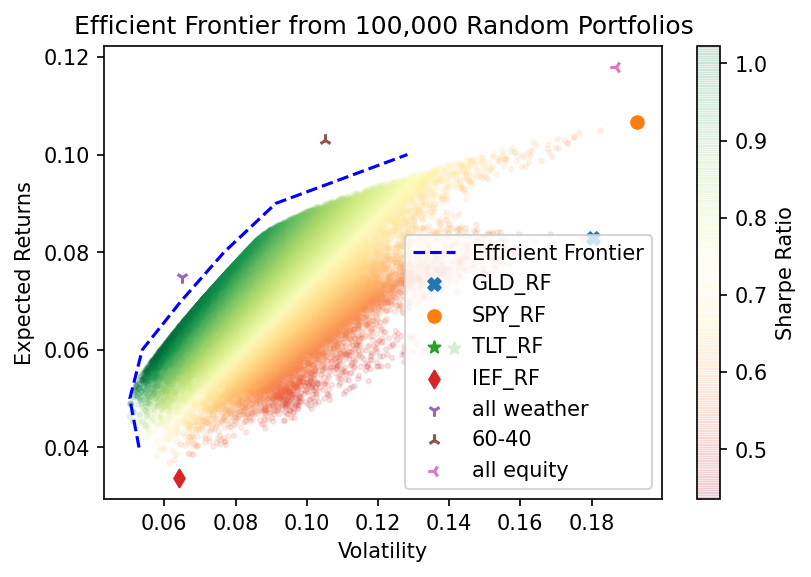

In [81]:
MARKS = {
    'SPY_RF': 'o', 
    'GLD_RF': 'X', 
    'IEF_RF': 'd', 
    'TLT_RF': '*',
    'All weather': '1',
    '60-40 port': '2',
    'All equity': '3',
}

NAMES = {
    'sharpe_ratio': 'Sharpe Ratio'
}

fig, ax = plt.subplots()
portf_results_df.rename(columns=NAMES).plot(
    kind='scatter',
    marker='.',
    alpha=0.1,
    x='volatility',
    y='returns', 
    c='Sharpe Ratio',
    cmap='RdYlGn',
    ax=ax
)

portf_rtns_ef.plot(
    kind='line',
    style='b--',
    label='Efficient Frontier',
    x='volatility',
    y='returns_',
    ax=ax
)

for s in new_port_r1.columns:
    ax.scatter(
        x=np.sqrt(cov_mat.loc[s, s]), 
        y=avg_returns.loc[s], 
        marker=MARKS[s], 
        label=s
    )
plt.scatter(0.065, 0.075, marker='1',
            label='all weather')
plt.scatter(0.105, 0.103, marker='2',
            label='60-40')
plt.scatter(0.187, 0.118, marker='3',
            label='all equity')
    
plt.legend()


ax.set(
    xlabel='Volatility', 
    ylabel='Expected Returns', 
    title='Efficient Frontier from 100,000 Random Portfolios'
)

plt.show()

## **Conclusion**

In conclusion, All Weather Portfolio fares better in every factor that was analyzed in this investigation. 

Starting with the risk contribution, all weather portfolio is a risk parity portfolio which is beneficial for the investor in all kinds of market conditions. 

Next, even though the weighted returns of All Weather are the lowest among the three, it has the highest Sharpe ratio, which is an important factor that an investor looks at, in the very beginning. 

Furthermore, it has low volatility and presents a conservative growth unlike an all equity index fund. Now this is not a bad thing since it protects the investor from the downside volatility. All Weather portfolio also has the least MDD (Maximum Draw Downs), while the all equity portfolio has the highest MDD.

Lastly, with leverage, this portfolio can increase the return (by matching the return with an all equity portfolio).

All in all, you should invest in an All Weather Portfolio.
